# Spark and Data Science Libraries Sample Notebook

This notebook demonstrates how to use PySpark in conjunction with pandas, numpy, scikit-learn and LightGBM for data analysis and machine learning tasks.

Created: May 7, 2025

## 1. Setting up the Spark Session

In [1]:
import os
import pyspark
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("SparkDataScienceSample") \
    .master(os.environ.get("SPARK_MASTER", "spark://spark-master:7077")) \
    .config("spark.executor.memory", "1g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark version: 4.0.0-preview2
Spark UI available at: http://f03ad6f670ed:4040


## 2. Creating Sample Data with PySpark

In [2]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import random

# Create a schema for our data
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("category", StringType(), False),
    StructField("value1", DoubleType(), False),
    StructField("value2", DoubleType(), False),
    StructField("target", IntegerType(), False)
])

# Generate some random data
categories = ["A", "B", "C", "D"]
data = []

for i in range(1000):
    category = random.choice(categories)
    value1 = random.uniform(0, 100)
    value2 = random.uniform(0, 100)
    # Simple rule: if value1 > 50 and category is A or B, target is 1, otherwise 0
    target = 1 if (value1 > 50 and category in ["A", "B"]) else 0
    data.append(Row(id=i, category=category, value1=value1, value2=value2, target=target))

# Create a DataFrame
df = spark.createDataFrame(data)

# Show a sample of the data
df.show(5)
print(f"Total records: {df.count()}")

# Show basic statistics
df.describe().show()

+---+--------+------------------+------------------+------+
| id|category|            value1|            value2|target|
+---+--------+------------------+------------------+------+
|  0|       A|30.169550612089747| 69.40592398786046|     0|
|  1|       A|14.483127885395541|29.167898618446443|     0|
|  2|       D| 68.17267875232366| 2.996110778587213|     0|
|  3|       B| 34.63596497544135|2.8652084768264308|     0|
|  4|       D|  74.7196552390167|  6.03413118650743|     0|
+---+--------+------------------+------------------+------+
only showing top 5 rows

Total records: 1000
+-------+-----------------+--------+-------------------+-------------------+------------------+
|summary|               id|category|             value1|             value2|            target|
+-------+-----------------+--------+-------------------+-------------------+------------------+
|  count|             1000|    1000|               1000|               1000|              1000|
|   mean|            499.5|    

## 3. Converting Spark DataFrame to Pandas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Display pandas DataFrame info
print("Pandas DataFrame Information:")
pandas_df.info()

# Basic statistics with pandas
print("\nBasic Statistics:")
print(pandas_df.describe())

# Display correlation between numeric columns
correlation = pandas_df[["value1", "value2", "target"]].corr()
print("\nCorrelation Matrix:")
print(correlation)

Pandas DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1000 non-null   int64  
 1   category  1000 non-null   object 
 2   value1    1000 non-null   float64
 3   value2    1000 non-null   float64
 4   target    1000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB

Basic Statistics:
                id       value1       value2       target
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    499.500000    50.314438    50.051010     0.244000
std     288.819436    28.756387    29.105580     0.429708
min       0.000000     0.100885     0.160866     0.000000
25%     249.750000    25.665408    24.774395     0.000000
50%     499.500000    49.396046    50.399688     0.000000
75%     749.250000    75.000451    75.528169     0.000000
max     999.000000    99.939197    99.950574  

## 4. Data Visualization

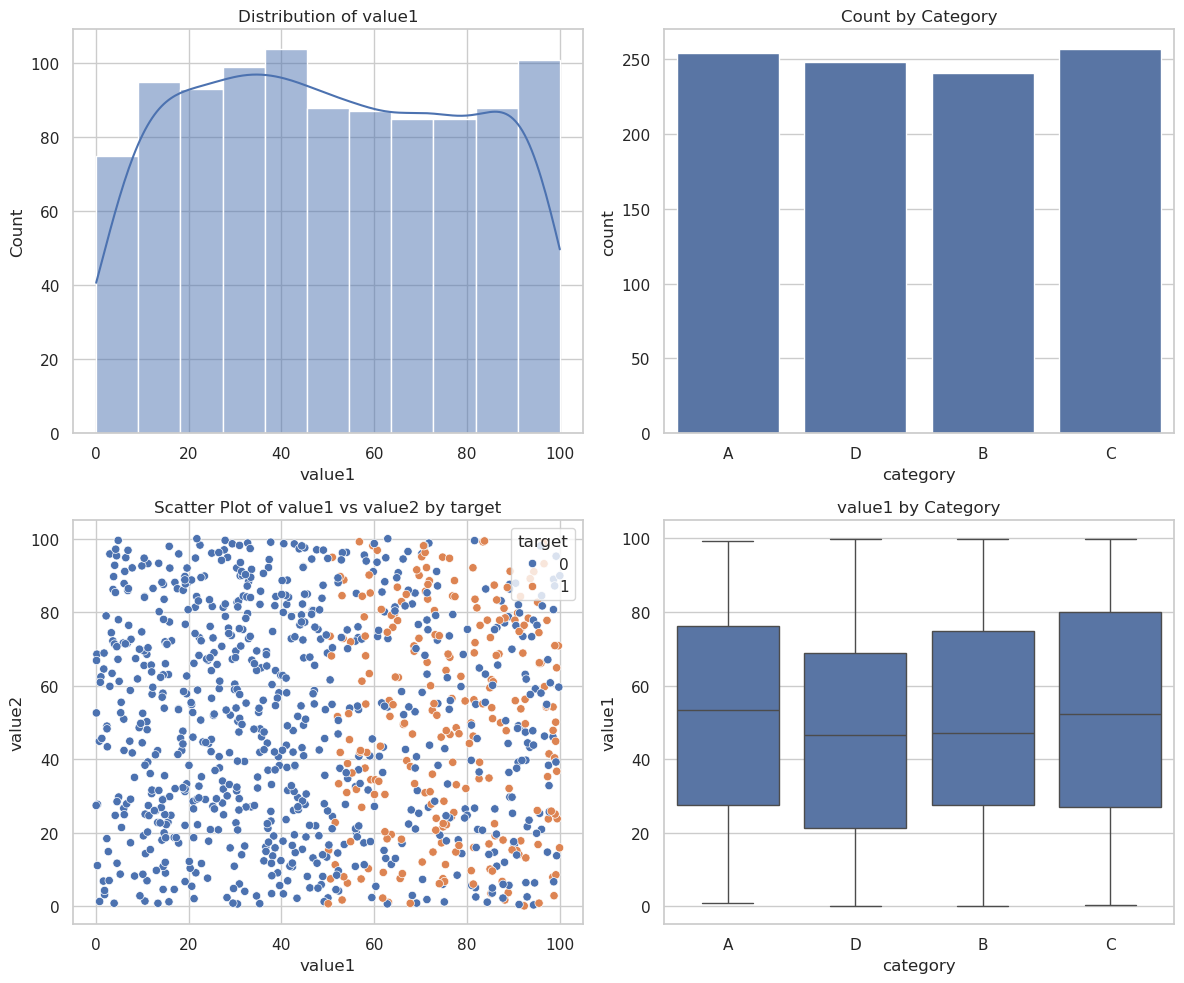

In [5]:
# Set the style for plots
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# Create a subplot grid
plt.subplot(2, 2, 1)
sns.histplot(pandas_df["value1"], kde=True)
plt.title("Distribution of value1")

plt.subplot(2, 2, 2)
sns.countplot(x="category", data=pandas_df)
plt.title("Count by Category")

plt.subplot(2, 2, 3)
sns.scatterplot(x="value1", y="value2", hue="target", data=pandas_df)
plt.title("Scatter Plot of value1 vs value2 by target")

plt.subplot(2, 2, 4)
sns.boxplot(x="category", y="value1", data=pandas_df)
plt.title("value1 by Category")

plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [6]:
# Let's add some features using numpy and pandas
pandas_df["value_ratio"] = pandas_df["value1"] / (pandas_df["value2"] + 1)  # Adding 1 to avoid division by zero
pandas_df["value_sum"] = pandas_df["value1"] + pandas_df["value2"]
pandas_df["value_diff"] = np.abs(pandas_df["value1"] - pandas_df["value2"])
pandas_df["value1_log"] = np.log1p(pandas_df["value1"])  # log1p to avoid issues with zero

# Create dummy variables for category
category_dummies = pd.get_dummies(pandas_df["category"], prefix="category")
pandas_df = pd.concat([pandas_df, category_dummies], axis=1)

# Display the DataFrame with new features
print("DataFrame with new features:")
pandas_df.head()

DataFrame with new features:


,id,category,value1,value2,target,value_ratio,value_sum,value_diff,value1_log,category_A,category_B,category_C,category_D
0,0,A,30.169551,69.405924,0,0.428509,99.575475,39.236373,3.439442,True,False,False,False
1,1,A,14.483128,29.167899,0,0.480084,43.651027,14.684771,2.739751,True,False,False,False
2,2,D,68.172679,2.996111,0,17.059757,71.168790,65.176568,4.236606,False,False,False,True
3,3,B,34.635965,2.865208,0,8.960956,37.501173,31.770756,3.573355,False,True,False,False
4,4,D,74.719655,6.034131,0,10.622443,80.753786,68.685524,4.327038,False,False,False,True


## 6. Machine Learning with Scikit-Learn

Random Forest Performance:
Accuracy: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00        44

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



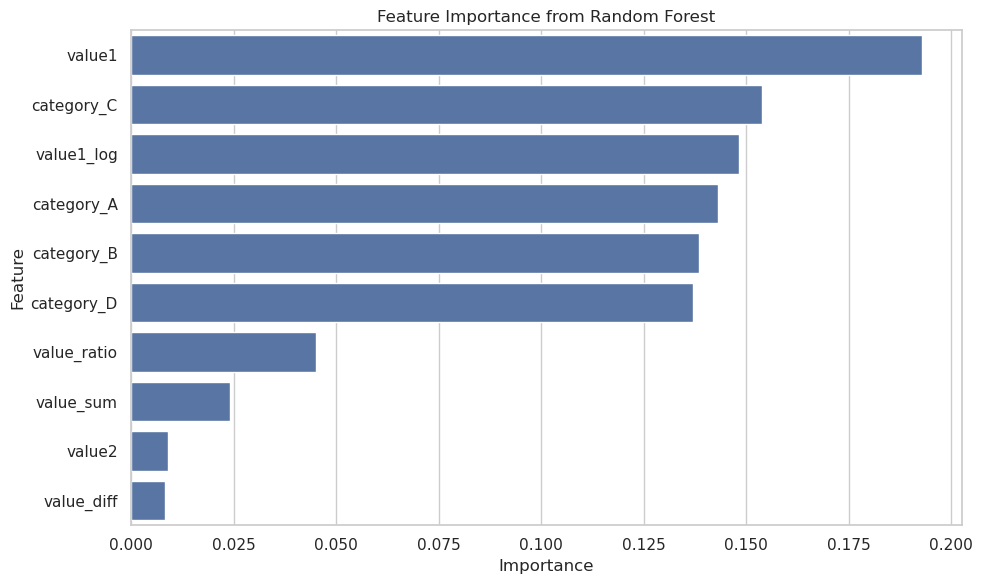

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Select features for model training
features = ["value1", "value2", "value_ratio", "value_sum", "value_diff", "value1_log", 
            "category_A", "category_B", "category_C", "category_D"]
X = pandas_df[features]
y = pandas_df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

## 7. Advanced ML with LightGBM

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_test = lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)

# Set parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
print("Training LightGBM model...")
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=100,
                      valid_sets=[lgb_train, lgb_test],
                      # early_stopping_rounds=10
                     )

# Make predictions
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_binary_pred = [1 if pred > 0.5 else 0 for pred in lgb_pred]

# Evaluate the model
print("\nLightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, lgb_binary_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, lgb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgb_binary_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("Feature Importance from LightGBM")
plt.tight_layout()
plt.show()

Training LightGBM model...


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

## 8. Going Back to Spark - Saving Results to Spark DataFrame

In [ ]:
# Add predictions to our pandas DataFrame
test_indices = pandas_df.iloc[y_test.index].index
pandas_df.loc[test_indices, "rf_prediction"] = y_pred
pandas_df.loc[test_indices, "rf_probability"] = y_prob
pandas_df.loc[test_indices, "lgb_prediction"] = lgb_binary_pred
pandas_df.loc[test_indices, "lgb_probability"] = lgb_pred

# Convert back to a Spark DataFrame
result_spark_df = spark.createDataFrame(pandas_df)
result_spark_df.show(5)

# Register as a temporary view for SQL queries
result_spark_df.createOrReplaceTempView("model_results")

# Example: Run a Spark SQL query
print("\nAnalyzing model results using Spark SQL:")
spark.sql("""
SELECT 
    category,
    COUNT(*) as total_count,
    SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) as actual_positive,
    SUM(CASE WHEN rf_prediction = 1 THEN 1 ELSE 0 END) as rf_predicted_positive,
    SUM(CASE WHEN lgb_prediction = 1 THEN 1 ELSE 0 END) as lgb_predicted_positive
FROM model_results
GROUP BY category
ORDER BY category
""").show()

## 9. Close Spark Session when Done

In [ ]:
# Stop the Spark session
# Uncomment this when you want to close the Spark session
# spark.stop()

print("Notebook completed successfully!")